---
title: "Eager Mode Quantization in PyTorch for Object Detection"
author: "me"
date: 2023-11-15
date-modified: "11/22/2023"
draft: false
---

At the time of writing this quantization in PyTorch was relatively new to me, and I wanted a deep dive on the topic for something non-trivial.  After reading about different [quantization modes](https://pytorch.org/docs/stable/quantization.html#quantization-api-summary) (eager vs graph fx) as well as quantization methods (dynamic, static post-training, static aware-training), I decide to try eager mode quantization aware training (QAT).

In my research for a project, I came across [multiple discussions](https://github.com/pytorch/pytorch/issues/31316) online requesting either [help](https://discuss.pytorch.org/t/slow-inference-time-on-quantized-faster-rcnn-model/115182) or a [tutorial](https://discuss.pytorch.org/t/tutorial-on-quantizing-object-detection-model/102604) for quantizing the backbone of an object detection model (faster R-CNN in this case).  As far as I could tell there was nothing available so this was the perfect excuse.

So in this post, I will go through that process of quantization-aware training and include some analysis on the benefits of quantization.

### ResNet and Feature Pyramid Network

This assumes some familiarity with the R-CNN architecture, but to refresh, the feature extraction backbone consists of two components; the resnet and the feature pyramid network.  The FPN combines output from consecutive layers of the resnet (via upsampling) which allows it to extract semantic information at higher resolutions.  These two components of the backbone can be quantized while the rest of the network still uses floating point precision.

From an implementation standpoint, there is a utility class [IntermediateLayerGetter](https://github.com/pytorch/vision/blob/main/torchvision/models/_utils.py#L13) for extracting each layer output (no fully connected) from the resnet.  And another convenience class for the [FPN](https://github.com/pytorch/vision/blob/main/torchvision/ops/feature_pyramid_network.py#L36) which takes the layer ouputs as input.  Combining these two is [BackboneWithFPN](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/backbone_utils.py#L13) which is mostly just a thin wrapper around both.

As we are doing eager mode static quantization, we'll need to [prepare the model](https://pytorch.org/docs/stable/quantization.html#model-preparation-for-eager-mode-static-quantization) before we can train it and subsequently quantize it.

### Model Preparation

The first step in preparing the network for quantization is to create a modified [bottleneck block](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L108).  This isn't obvious until you try to quantize the ResNet without it.  You will get an error `.. out += identity .. Could not run 'aten::add.out' ..` which means that PyTorch isn't able to quantize the skip connection using the `+=` operator in eager mode.  [This discussion on the pytorch forums](https://discuss.pytorch.org/t/quantizing-an-existing-object-detector-with-resnet-backbone/134627) was helpful for describing the error as well as how to fix it.  The modified bottleneck block just uses [FloatFunctional](https://pytorch.org/docs/stable/generated/torch.ao.nn.quantized.FloatFunctional.html) which has a quantized addition operator.  I'm using ResNet 101 here but for much smaller networks you would want to modify the basic block.  Also, the original bottleneck class reuses the ReLU layer which won't work when fusing.  Finding [this blog post](https://leimao.github.io/blog/PyTorch-Static-Quantization/) about quantizing ResNet was helpful for realizing and avoiding that pitfall.

In [ ]:
from typing import Optional, Callable

import torch.nn as nn
from torch import Tensor
from torch.ao.nn.quantized import FloatFunctional

from torchvision.models.resnet import conv1x1, conv3x3


class BottleneckQuantizeable(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.ff_add = FloatFunctional()

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.ff_add.add(out, identity)
        out = self.relu3(out)

        return out


Now that we have a quantizeable bottleneck, we can simply reference it when generating the ResNet.  Even though the float functional operator was added, we can still load pretrained imagenet weights since the trainable submodules didn't change.  Note that the number of classes for the ResNet don't matter here because we will extract intermediate layers and ignore the final fully connected layer.

In [ ]:
from torchvision.models.resnet import ResNet, ResNet50_Weights, ResNet101_Weights


def resnet_101():
    resnet = ResNet(block=BottleneckQuantizeable, layers=[3, 4, 23, 3])
    resnet.load_state_dict(ResNet101_Weights.DEFAULT.get_state_dict(progress=True))
    return resnet


resnet = resnet_101()

The next step would be to pass the resnet to the `IntermediateLayerGetter`.  In addition to the resnet we created, this class also requires a dictionary of the layer names (to know what to extract).  It returns an `OrderedDict` of those layer outputs.  Here's an example using a toy image.

In [ ]:
import torch
from torchvision.models._utils import IntermediateLayerGetter


returned_layers = [1, 2, 3, 4]  # get all 4 layers
return_layers = {f"layer{k}": str(v) for v, k in enumerate(returned_layers)}  # {'layer1': 0, 'layer2': 1, ...}

resnet_layers = IntermediateLayerGetter(resnet, return_layers=return_layers)

out = resnet_layers(torch.rand(1, 3, 200, 200))  # e.g. 200 x 200 image with 3 channels
[(k, v.shape) for k, v in out.items()]

[('0', torch.Size([1, 256, 50, 50])),
 ('1', torch.Size([1, 512, 25, 25])),
 ('2', torch.Size([1, 1024, 13, 13])),
 ('3', torch.Size([1, 2048, 7, 7]))]

As mentioned, the output of the resnet layers will be fed to the feature pyramid network.  Before we can do this, the FPN also needs to be modified as it uses the addition operator `+`.  There is also a functional `F.interpolate` that doesn't need to be replaced, however it does need to be referenced differently as importing `torch.nn.functional as F` causes a namespace issue later with `torchvision` and QAT will fail.

In [ ]:
from collections import OrderedDict
from typing import List, Dict

# importing as 'F' causes namespace collision with torchvision and QAT fails later
# import torch.nn.functional as F
import torch

from torchvision.ops.misc import Conv2dNormActivation
from torchvision.utils import _log_api_usage_once
from torchvision.ops.feature_pyramid_network import ExtraFPNBlock


class FeaturePyramidNetworkQuantizeable(nn.Module):
    """
    Module that adds a FPN from on top of a set of feature maps. This is based on
    `"Feature Pyramid Network for Object Detection" <https://arxiv.org/abs/1612.03144>`_.

    The feature maps are currently supposed to be in increasing depth
    order.

    The input to the model is expected to be an OrderedDict[Tensor], containing
    the feature maps on top of which the FPN will be added.

    Args:
        in_channels_list (list[int]): number of channels for each feature map that
            is passed to the module
        out_channels (int): number of channels of the FPN representation
        extra_blocks (ExtraFPNBlock or None): if provided, extra operations will
            be performed. It is expected to take the fpn features, the original
            features and the names of the original features as input, and returns
            a new list of feature maps and their corresponding names
        norm_layer (callable, optional): Module specifying the normalization layer to use. Default: None

    Examples::

        >>> m = torchvision.ops.FeaturePyramidNetwork([10, 20, 30], 5)
        >>> # get some dummy data
        >>> x = OrderedDict()
        >>> x['feat0'] = torch.rand(1, 10, 64, 64)
        >>> x['feat2'] = torch.rand(1, 20, 16, 16)
        >>> x['feat3'] = torch.rand(1, 30, 8, 8)
        >>> # compute the FPN on top of x
        >>> output = m(x)
        >>> print([(k, v.shape) for k, v in output.items()])
        >>> # returns
        >>>   [('feat0', torch.Size([1, 5, 64, 64])),
        >>>    ('feat2', torch.Size([1, 5, 16, 16])),
        >>>    ('feat3', torch.Size([1, 5, 8, 8]))]

    """

    _version = 2

    def __init__(
        self,
        in_channels_list: List[int],
        out_channels: int,
        extra_blocks: Optional[ExtraFPNBlock] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ):
        super().__init__()
        _log_api_usage_once(self)
        self.inner_blocks = nn.ModuleList()
        self.layer_blocks = nn.ModuleList()
        for in_channels in in_channels_list:
            if in_channels == 0:
                raise ValueError("in_channels=0 is currently not supported")
            inner_block_module = Conv2dNormActivation(
                in_channels, out_channels, kernel_size=1, padding=0, norm_layer=norm_layer, activation_layer=None
            )
            layer_block_module = Conv2dNormActivation(
                out_channels, out_channels, kernel_size=3, norm_layer=norm_layer, activation_layer=None
            )
            self.inner_blocks.append(inner_block_module)
            self.layer_blocks.append(layer_block_module)

        # initialize parameters now to avoid modifying the initialization of top_blocks
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        if extra_blocks is not None:
            if not isinstance(extra_blocks, ExtraFPNBlock):
                raise TypeError(f"extra_blocks should be of type ExtraFPNBlock not {type(extra_blocks)}")
        self.extra_blocks = extra_blocks
        self.ff_add = FloatFunctional()

    def _load_from_state_dict(
        self,
        state_dict,
        prefix,
        local_metadata,
        strict,
        missing_keys,
        unexpected_keys,
        error_msgs,
    ):
        version = local_metadata.get("version", None)

        if version is None or version < 2:
            num_blocks = len(self.inner_blocks)
            for block in ["inner_blocks", "layer_blocks"]:
                for i in range(num_blocks):
                    for type in ["weight", "bias"]:
                        old_key = f"{prefix}{block}.{i}.{type}"
                        new_key = f"{prefix}{block}.{i}.0.{type}"
                        if old_key in state_dict:
                            state_dict[new_key] = state_dict.pop(old_key)

        super()._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            strict,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )

    def get_result_from_inner_blocks(self, x: Tensor, idx: int) -> Tensor:
        """
        This is equivalent to self.inner_blocks[idx](x),
        but torchscript doesn't support this yet
        """
        num_blocks = len(self.inner_blocks)
        if idx < 0:
            idx += num_blocks
        out = x
        for i, module in enumerate(self.inner_blocks):
            if i == idx:
                out = module(x)
        return out

    def get_result_from_layer_blocks(self, x: Tensor, idx: int) -> Tensor:
        """
        This is equivalent to self.layer_blocks[idx](x),
        but torchscript doesn't support this yet
        """
        num_blocks = len(self.layer_blocks)
        if idx < 0:
            idx += num_blocks
        out = x
        for i, module in enumerate(self.layer_blocks):
            if i == idx:
                out = module(x)
        return out

    def forward(self, x: Dict[str, Tensor]) -> Dict[str, Tensor]:
        """
        Computes the FPN for a set of feature maps.

        Args:
            x (OrderedDict[Tensor]): feature maps for each feature level.

        Returns:
            results (OrderedDict[Tensor]): feature maps after FPN layers.
                They are ordered from the highest resolution first.
        """
        # unpack OrderedDict into two lists for easier handling
        names = list(x.keys())
        x = list(x.values())

        last_inner = self.get_result_from_inner_blocks(x[-1], -1)
        results = []
        results.append(self.get_result_from_layer_blocks(last_inner, -1))

        for idx in range(len(x) - 2, -1, -1):
            inner_lateral = self.get_result_from_inner_blocks(x[idx], idx)
            feat_shape = inner_lateral.shape[-2:]
            inner_top_down = torch.nn.functional.interpolate(last_inner, size=feat_shape, mode="nearest")
            # last_inner = inner_lateral + inner_top_down
            last_inner = self.ff_add.add(inner_lateral, inner_top_down)
            results.insert(0, self.get_result_from_layer_blocks(last_inner, idx))

        if self.extra_blocks is not None:
            results, names = self.extra_blocks(results, x, names)

        # make it back an OrderedDict
        out = OrderedDict([(k, v) for k, v in zip(names, results)])

        return out


As you can see from the signature of the modified FPN, it also needs to know input dimensions of each layer from the resnet.  There are several ways to get this but one way is to simply get the number of features in the final module of each layer.

In [ ]:
# from backbone_utils.py
# https://github.com/pytorch/vision/blob/main/torchvision/models/detection/backbone_utils.py#L145
# in_channels_stage2 = res101_layers.inplanes // 8
# in_channels_list = [in_channels_stage2 * 2 ** (i - 1) for i in returned_layers]

in_channels_list = []
for k1, m1 in resnet.named_children():
  if 'layer' in k1:
    in_channels_list.append((m1[-1].bn3.num_features))

in_channels_list

[256, 512, 1024, 2048]

Next step is to create a modified `BackboneWithFPN` that uses our `FeaturePyramidNetworkQuantizeable`.  Here we'll also make sure that the inputs are quantized and the outputs subsequently dequantized so that they can be fed to the R-CNN.

One important note is that regular `BatchNorm2d` is the default and used here instead of `FrozenBatchNorm2d`.  Frozen batch norm is the recommended layer because batches are generally [too small for good estimates of mean and variance](https://github.com/facebookresearch/maskrcnn-benchmark/issues/267) statistics but it isn't quantizeable.  So using regular batch norm could be unstable and less performant if those layers aren't frozen before training.

In [ ]:
from torchvision.ops.feature_pyramid_network import LastLevelMaxPool
from torchvision.models._utils import IntermediateLayerGetter
from torch.ao.quantization import QuantStub, DeQuantStub


class BackboneWithFPNQuantizeable(nn.Module):

    def __init__(
        self,
        backbone: nn.Module,
        return_layers: Dict[str, str],
        in_channels_list: List[int],
        out_channels: int,
        extra_blocks: Optional[ExtraFPNBlock] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()

        self.quant = QuantStub()
        self.dequant = DeQuantStub()

        if extra_blocks is None:
            extra_blocks = LastLevelMaxPool()

        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.fpn = FeaturePyramidNetworkQuantizeable(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
            norm_layer=norm_layer
        )
        self.out_channels = out_channels

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        x = self.quant(x)
        x = self.body(x)
        x = self.fpn(x)
        for k, v in x.items():
            x[k] = self.dequant(v)
        return x


Now we can create the modified backbone with FPN.  Once created, there should be quant/dequant stubs visible in the network like so

```
BackboneWithFPNQuantizeable(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BottleneckQuantizeable(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        ...
```

In [ ]:
# resnet = resnet_101()
# returned_layers = [1, 2, 3, 4]
# return_layers = {f"layer{k}": str(v) for v, k in enumerate(returned_layers)}
# in_channels_list = []
# for k1, m1 in resnet.named_children():
#   if 'layer' in k1:
#     in_channels_list.append((m1[-1].bn3.num_features))

bbfpn = BackboneWithFPNQuantizeable(
    backbone=resnet,
    return_layers=return_layers,
    in_channels_list=in_channels_list,
    out_channels=256,
    extra_blocks=None,
    norm_layer=None,
)
# bbfpn

Now the backbone with FPN can be plugged into the [FasterRCNN](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py#L43).  The number of classes is set to 2 for either object or background which is specific to the dataset used here.

In [ ]:
from torchvision.models.detection.faster_rcnn import FasterRCNN


quant_rcnn = FasterRCNN(bbfpn, num_classes=2)

### Layer Fusion and Quantization Config

Before training and subsequently converting the model, we can fuse specific sequences of modules in the backbone.  Fusing compresses the model [making it smaller and run faster](https://pytorch.org/tutorials/recipes/fuse.html) by combining modules like `Conv2d-BatchNorm2d-ReLU` and `Conv2d-BatchNorm2d`.  After fusing you should see new fused modules in the network like `ConvReLU2d` as well as `Identity` where previous modules were.

```
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPNQuantizeable(
    (body): IntermediateLayerGetter(
      (conv1): ConvReLU2d(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): ReLU(inplace=True)
      )
      (bn1): Identity()
      (relu): Identity()
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BottleneckQuantizeable(
          (conv1): ConvReLU2d(
            (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
          )
          (bn1): Identity()
          (relu1): Identity()
          ...
```

In [ ]:
from torch.ao.quantization import fuse_modules


quant_rcnn.eval()
# fuse stem
fuse_modules(quant_rcnn.backbone.body, [['conv1', 'bn1', 'relu']], inplace=True)
# fuse blocks
for k1, m1 in quant_rcnn.backbone.body.named_children():
    if "layer" in k1:  # in sequential layer with blocks
        for k2, m2 in m1.named_children():
            fuse_modules(m2, [["conv1", "bn1", "relu1"], ["conv2", "bn2", "relu2"], ["conv3", "bn3"]], inplace=True)
            for k3, m3 in m2.named_children():
                if "downsample" in k3:  # fuse downsample
                    fuse_modules(m3, [["0", "1"]], inplace=True)

Before training the quantization config needs to be set (on the backbone only).  And again, because the batches are so small, [batch norm gets frozen](https://pytorch.org/docs/stable/generated/torch.ao.nn.intrinsic.qat.freeze_bn_stats.html) (see [this pytorch tutorial](https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html#quantization-aware-training) for another example).  Last, I'll freeze the stem and the first layer in the backbone since the pretrained imagenet weights were loaded.  After preparation you should be able to see the observers in the network.

```
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPNQuantizeable(
    (body): IntermediateLayerGetter(
      (conv1): ConvReLU2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)
        (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
          (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
        )
        (activation_post_process): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.]), zero_point=tensor([0], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
          (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
        )
      )
      (bn1): Identity()
      ...
```

In [ ]:
import re
import torch
from torch.ao.quantization import get_default_qat_qconfig, prepare_qat


quant_rcnn.train()
quant_rcnn.backbone.qconfig = get_default_qat_qconfig('fbgemm')
quant_rcnn_prepared = prepare_qat(quant_rcnn, inplace=False)

quant_rcnn_prepared = quant_rcnn_prepared.apply(torch.nn.intrinsic.qat.freeze_bn_stats)

quant_rcnn_prepared.backbone.body.conv1.weight.requires_grad = False
for name, parameter in quant_rcnn_prepared.backbone.named_parameters():
    if re.search(r".layer1", name):
        parameter.requires_grad = False

### Dataset, Training, and Conversion

I'll be using the [PennFudan dataset](https://www.cis.upenn.edu/~jshi/ped_html/) from the [Torchvision object detection finetuning tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) for QAT.  Most of the code below is borrowed from that tutorial with slight modifications and no segmentation.

In [ ]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F  # careful namespace 'F'
from torchvision.transforms import v2 as T


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


In [ ]:
%%capture

os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip -d ./

In [ ]:
import utils
from engine import train_one_epoch, evaluate


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

In [ ]:
# move model to the right device
quant_rcnn_prepared.to(device)

# construct an optimizer
params = [p for p in quant_rcnn_prepared.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 20 iterations
    train_one_epoch(quant_rcnn_prepared, optimizer, data_loader, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(quant_rcnn_prepared, data_loader_test, device=device)


Epoch: [0]  [ 0/60]  eta: 0:00:49  lr: 0.000090  loss: 1.5364 (1.5364)  loss_classifier: 0.8895 (0.8895)  loss_box_reg: 0.0007 (0.0007)  loss_objectness: 0.6395 (0.6395)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 0.8299  data: 0.1936  max mem: 6367
Epoch: [0]  [20/60]  eta: 0:00:25  lr: 0.001783  loss: 0.6043 (0.7210)  loss_classifier: 0.1105 (0.2343)  loss_box_reg: 0.0665 (0.0648)  loss_objectness: 0.3679 (0.3956)  loss_rpn_box_reg: 0.0270 (0.0263)  time: 0.6163  data: 0.0064  max mem: 6367
Epoch: [0]  [40/60]  eta: 0:00:12  lr: 0.003476  loss: 0.3219 (0.5298)  loss_classifier: 0.0957 (0.1841)  loss_box_reg: 0.1185 (0.0904)  loss_objectness: 0.0582 (0.2321)  loss_rpn_box_reg: 0.0194 (0.0233)  time: 0.6057  data: 0.0056  max mem: 6367
Epoch: [0]  [59/60]  eta: 0:00:00  lr: 0.005000  loss: 0.2767 (0.4805)  loss_classifier: 0.0943 (0.1721)  loss_box_reg: 0.1098 (0.0993)  loss_objectness: 0.0459 (0.1849)  loss_rpn_box_reg: 0.0160 (0.0242)  time: 0.6120  data: 0.0057  max mem: 6367
Epoch: [

Now to convert and save the model.  Make sure to put the model on CPU before conversion or you will get an error.  After conversion you should see quantized modules like `QuantizedConvReLU2d`.

```
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPNQuantizeable(
    (quant): Quantize(scale=tensor([0.0375]), zero_point=tensor([57]), dtype=torch.quint8)
    (dequant): DeQuantize()
    (body): IntermediateLayerGetter(
      (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.2553767263889313, zero_point=0, padding=(3, 3))
      (bn1): Identity()
      (relu): Identity()
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BottleneckQuantizeable(
          (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(1, 1), stride=(1, 1), scale=0.12423195689916611, zero_point=0)
          (bn1): Identity()
          (relu1): Identity()
          ...
```

In [ ]:
from torch.ao.quantization import convert


quant_rcnn_prepared.eval()
quant_rcnn_prepared.to(torch.device('cpu'))

quant_rcnn_converted = convert(quant_rcnn_prepared, inplace=False)

quant_model_path = "/content/quant_model.pth"
torch.save(quant_rcnn_converted.state_dict(), quant_model_path)

For comparison I'll generate the same network without any modifications made for quantization (including fusion).  Then we can compare model sizes and latency.  Note that this is just comparing latency on the CPU, if the float model was on GPU it could be significantly faster depending upon the hardware.

In [ ]:
%%capture
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.resnet import Bottleneck


resnet_bb = resnet_101()
rcnn = FasterRCNN(
    BackboneWithFPN(
        backbone=resnet_bb,
        return_layers=return_layers,
        in_channels_list=in_channels_list,
        out_channels=256,
        extra_blocks=None,
        norm_layer=None,
        ),
    num_classes=2
)

rcnn.eval()
rcnn.to(torch.device('cpu'))
model_path = "/content/float_model.pth"
torch.save(rcnn.state_dict(), model_path)

In [ ]:
print(f'size of quantized model: {round(os.path.getsize("/content/quant_model.pth") / 1e6)} MB')
print(f'size of float model: {round(os.path.getsize("/content/float_model.pth") / 1e6)} MB')

size of quantized model: 105 MB
size of float model: 242 MB


In [ ]:
from time import perf_counter


quant_rcnn_converted.to(torch.device('cpu'))
# just grab one test image/batch
images, targets = next(iter(data_loader_test))
images = list(img.to(torch.device('cpu')) for img in images)
n = 10

start = perf_counter()
for _ in range(n):
    __ = quant_rcnn_converted(images)
print(f"quant model avg time: {(perf_counter() - start) / n:.2f}")

start = perf_counter()
for _ in range(n):
    __ = rcnn(images)
print(f"float model avg time (cpu): {(perf_counter() - start) / n:.2f}")

quant model avg time: 1.42
float model avg time (cpu): 2.20


I believe a fully quantized model would be even smaller and faster by comparison.  In this case, while we did quantize the backbone for the RCNN, it only accounted for roughly 75% of the model parameters.  So a significant number of float operations still occur after the quantized backbone.

In [ ]:
num_model_params = sum(p.numel() for p in rcnn.parameters() if p.requires_grad)
num_backbone_params = sum(p.numel() for p in rcnn.backbone.parameters() if p.requires_grad)

print(f"total number of parameters in model: {num_model_params}")
print(f"total number of parameters in backbone: {num_backbone_params}")
print(f"ratio of quantized parameters: {num_backbone_params / num_model_params:.2f}")

total number of parameters in model: 60344409
total number of parameters in backbone: 45844544
ratio of quantized parameters: 0.76


We can also profile each model to see where each spends the most time during a forward pass.

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity


with profile(activities=[ProfilerActivity.CPU], record_shapes=False) as prof:
    with record_function("model_inference"):
        quant_rcnn_converted(images)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

with profile(activities=[ProfilerActivity.CPU], record_shapes=False) as prof:
    with record_function("model_inference"):
        rcnn(images)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         2.15%      29.904ms       100.00%        1.388s        1.388s             1  
           quantized::conv2d_relu        26.61%     369.449ms        26.96%     374.209ms       5.585ms            67  
                quantized::conv2d        23.33%     323.889ms        23.44%     325.335ms       7.230ms            45  
           torchvision::roi_align        17.54%     243.538ms        20.78%     288.475ms      72.119ms             4  
                     aten::conv2d         0.00%      64.000us        13.45%     186.652ms      12.443ms            15  
                aten::convolution       

The following loads the saved quantized model.  It's important that the same process of [fusing, preparing, and converting](https://discuss.pytorch.org/t/how-to-load-quantized-model-for-inference/140283) be done before loading weights since quantization significantly alters the network.  For sake of completeness, we can look at a prediction from the partially quantized RCNN.

In [ ]:
%%capture

quant_model_loaded = FasterRCNN(
    BackboneWithFPNQuantizeable(
        backbone=resnet_101(),
        return_layers=return_layers,
        in_channels_list=in_channels_list,
        out_channels=256,
        extra_blocks=None,
        norm_layer=None
        ),
    num_classes=2
    )

quant_model_loaded.eval()
fuse_modules(quant_model_loaded.backbone.body, [['conv1', 'bn1', 'relu']], inplace=True)
for k1, m1 in quant_model_loaded.backbone.body.named_children():
    if "layer" in k1:  # in sequential layer with blocks
        for k2, m2 in m1.named_children():
            fuse_modules(m2, [["conv1", "bn1", "relu1"], ["conv2", "bn2", "relu2"], ["conv3", "bn3"]], inplace=True)
            for k3, m3 in m2.named_children():
                if "downsample" in k3:  # fuse downsample
                    fuse_modules(m3, [["0", "1"]], inplace=True)

quant_model_loaded.train()
quant_model_loaded.backbone.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare_qat(quant_model_loaded, inplace=True)
torch.quantization.convert(quant_model_loaded, inplace=True)

quant_model_loaded.eval()
quant_model_loaded.load_state_dict(torch.load(quant_model_path, map_location=torch.device('cpu')))

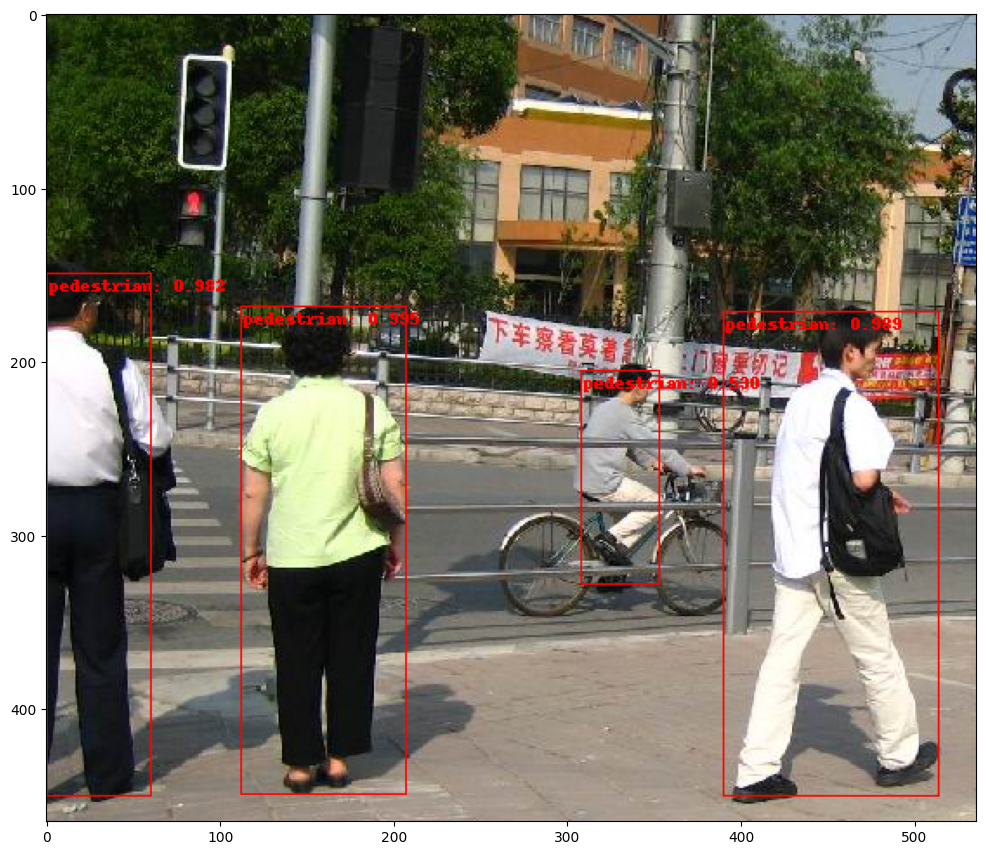

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("PennFudanPed/PNGImages/FudanPed00022.png")  # 7, 22
eval_transform = get_transform(train=False)

with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(torch.device('cpu'))
    predictions = quant_model_loaded([x, ])
    pred = predictions[0]

threshold = 0.50
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"]) if score > threshold]
pred_boxes = pred["boxes"].long()[pred["scores"] > threshold]

output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

It's worth mentioning that I ran into all sorts of issues on my early attempts.  This post is polished and makes the whole process look linear but it wasn't.  There were many attempts, breaks to research bugs, figuring out how to do something, reverting to simpler models, etc.  Things failed and failed until finally they didn't.